In [1]:
%run packages_imported.py
%run EDA.py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [2]:
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')

In [3]:
t1 = time.time() 
X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 0 seconds


## SVM

Full dataset

In [8]:
t1 = time.time() 

tfidfconverter = TfidfVectorizer(min_df=0.0001, max_df=0.98)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))


EDA.process_time(round(time.time()-t1))


MemoryError: Unable to allocate 76.7 GiB for an array with shape (221982, 46391) and data type float64

In [3]:
import dask_ml
import dask_ml.feature_extraction.text
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.model_selection import train_test_split

In [4]:
import dask.dataframe as dd
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')
df_all_news_processed = dd.from_pandas(df_all_news_processed, npartitions=3)
df_all_news_processed.head()

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show sinc...,tracy morgan performs first stand-up show sinc...,entertainment,186
1,President Barack Obama interviews author Maril...,information president barack obama interviews ...,entertainment,148
2,"I will perform at night clubs, shows β€“ Pasto...",source ghana hitz euphemia akpalu date time pm...,entertainment,181
3,MEG Records' Country Star Tom MacLear will be ...,records latest music news maclear 40 country s...,entertainment,196
4,Defeat the Zombie Apocalypse,defeat zombie apocalypse zombie hunting tukwil...,entertainment,24


In [5]:
########### DASK 
t1 = time.time() 


X = df_all_news_processed["Text"].compute().tolist()
Y = df_all_news_processed["Category"].compute().tolist()

dask_vectorizer = HashingVectorizer(ngram_range=(1, 2))

X = dask_vectorizer.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [6]:
svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.8232    0.8655    0.8438      6401
    financial     0.8171    0.8105    0.8138      6339
    political     0.7339    0.7672    0.7502      6108
        sport     0.8675    0.8598    0.8636      6471
   technology     0.7526    0.7440    0.7483      6051
       travel     0.8727    0.8260    0.8487      6582
        world     0.7244    0.7157    0.7200      6445

     accuracy                         0.7992     44397
    macro avg     0.7988    0.7984    0.7984     44397
 weighted avg     0.7999    0.7992    0.7993     44397

Accuracy score: 0.7991530959299051
Process completed.
Time taken: 31h 10mins 38secs


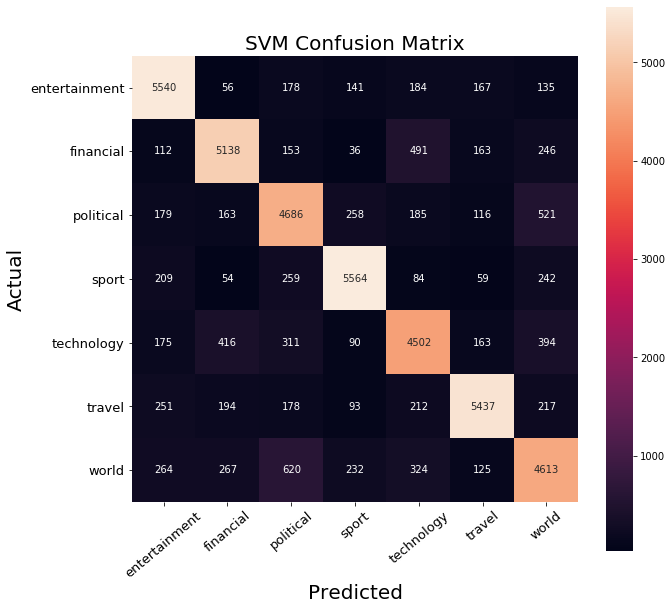

In [12]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix")

In [21]:
# Save the model as pickle
model_pkl = "svc_full_dataset.pkl"  

with open("data/"+model_pkl, 'wb') as file:  
    pickle.dump(svc, file)

In [29]:
mystring = ["The 60-year-old leader of Chancellor Merkel's centre-right Christian Democrats (CDU) is premier of heavily industrial North Rhine-Westphalia (NRW), Germany's most populous state.Despite years of top-level political experience he struggled against a Bavarian rival for the candidacy - Markus Söder, leader of the CDU's junior partner, the Christian Social Union (CSU). Finally the Christian Democrat leadership rallied behind Mr Laschet, who now has to woo Mr Söder's many supporters.The pandemic has exacted a political toll on the two conservative parties: their support has slumped to roughly 28\% according to polls.Mr Laschet is the son of a mining engineer and for years defended Germany's powerful coal industry. He was late to back protection of the Hambach Forest near Cologne: much of it had already been felled to make way for brown coal (lignite) mining. Some question his commitment to decarbonisation, when the Greens are polling strongly and CO2 cuts are legally binding."]

#dask_vectorizer = HashingVectorizer(ngram_range=(1, 2))

asdf = dask_vectorizer.fit_transform(mystring)

svc.predict(asdf)

array(['political'], dtype='<U13')

Small dataset post distribution

In [2]:
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_before_tuning')

X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

In [3]:
t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC(random_state = 42))])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

tuned_parameters = {
    'tfidf__min_df': [0.001, 0.001, 0.0001, 0.00001],
    'tfidf__max_df': [0.98, 0.93, 0.88, 0.83],
    'tfidf__use_idf': (True, False),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'svc__C': [10],
    'svc__gamma': [0.1],
    'svc__kernel': ['sigmoid']
}

svc = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')


svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", svc.best_score_)
print("Best Params: ", svc.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7422    0.8227    0.7804       203
    financial     0.7489    0.7321    0.7404       224
    political     0.6127    0.5955    0.6040       178
        sport     0.8250    0.7674    0.7952       215
   technology     0.6009    0.6995    0.6465       183
       travel     0.7778    0.7151    0.7451       186
        world     0.6734    0.6351    0.6537       211

     accuracy                         0.7121      1400
    macro avg     0.7116    0.7096    0.7093      1400
 weighted avg     0.7154    0.7121    0.7125      1400

Best Score:  0.7246428571428571
Best Params:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid', 'tfidf__max_df': 0.98, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}
Process completed.
Time taken: 15h 35mins 46secs


AttributeError: 'list' object has no attribute 'drop_duplicates'

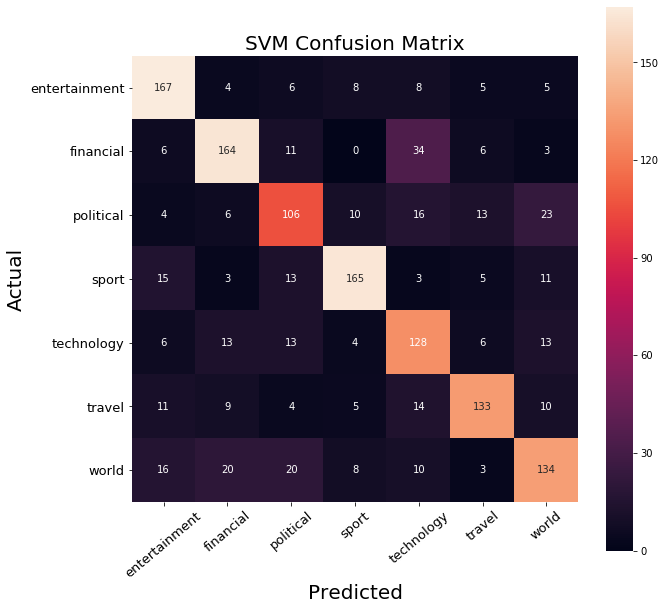

In [4]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix")

In [7]:
import dask_ml
import dask_ml.feature_extraction.text
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.model_selection import train_test_split

In [3]:
import dask.dataframe as dd
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_before_tuning')
df_all_news_processed = dd.from_pandas(df_all_news_processed, npartitions=3)
df_all_news_processed.head()

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show sinc...,tracy morgan performs first stand-up show sinc...,entertainment,186
1,President Barack Obama interviews author Maril...,information president barack obama interviews ...,entertainment,148
2,"I will perform at night clubs, shows β€“ Pasto...",source ghana hitz euphemia akpalu date time pm...,entertainment,181
3,MEG Records' Country Star Tom MacLear will be ...,records latest music news maclear 40 country s...,entertainment,196
4,Defeat the Zombie Apocalypse,defeat zombie apocalypse zombie hunting tukwil...,entertainment,24


In [4]:
import dask_ml
import dask_ml.feature_extraction.text
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.model_selection import train_test_split

In [ ]:
########### DASK 
t1 = time.time() 


X = df_all_news_processed["Text"].compute().tolist()
Y = df_all_news_processed["Category"].compute().tolist()

dask_vectorizer = HashingVectorizer(ngram_range=(1, 2))

X = dask_vectorizer.fit_transform(X)

x_train, y_test, y_train, y_test = train_test_split(X.compute().toarray(), Y, test_size=0.2, random_state=42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


               precision    recall  f1-score   support

entertainment     0.7751    0.7980    0.7864       203
    financial     0.7596    0.7054    0.7315       224
    political     0.5381    0.6348    0.5825       178
        sport     0.8113    0.8000    0.8056       215
   technology     0.6040    0.6667    0.6338       183
       travel     0.8862    0.7014    0.7831       211
        world     0.6302    0.6505    0.6402       186

     accuracy                         0.7114      1400
    macro avg     0.7149    0.7081    0.7090      1400
 weighted avg     0.7232    0.7114    0.7148      1400

Accuracy score: 0.7114285714285714
Process completed.
Time taken: 6mins 36secs


In [37]:
dask_ml.metrics.accuracy_score(y_test, y_pred)

AttributeError: 'list' object has no attribute 'ndim'

In [20]:
import dask_ml.wrappers
import sklearn.pipeline
svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)
clf = dask_ml.wrappers.Incremental(
    svc, scoring='accuracy', assume_equal_chunks=True
)
pipe = sklearn.pipeline.make_pipeline(dask_vectorizer, clf)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [32]:
import dask.array
x_train.to_dask_array()

AttributeError: to_dask_array not found

In [29]:
pipe.fit(x_train, y_train.toarray())

MemoryError: Unable to allocate 43.8 GiB for an array with shape (5600, 1048576) and data type float64

In [53]:



#svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


               precision    recall  f1-score   support

entertainment     0.1683    0.4187    0.2401       203
    financial     0.4105    0.1741    0.2445       224
    political     0.5556    0.1404    0.2242       178
        sport     0.6486    0.2233    0.3322       215
   technology     0.3735    0.1694    0.2331       183
       travel     0.4588    0.1848    0.2635       211
        world     0.1910    0.5269    0.2804       186

     accuracy                         0.2607      1400
    macro avg     0.4009    0.2625    0.2597      1400
 weighted avg     0.4037    0.2607    0.2609      1400

Accuracy score: 0.26071428571428573
Process completed.
Time taken: 15mins 25secs


lemma

In [3]:
t1 = time.time() 

df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_lemmatized')

X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

tfidfconverter = TfidfVectorizer(min_df=0.0001, max_df=0.98, use_idf=True, ngram_range = (1, 2))
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


MemoryError: Unable to allocate 52.2 GiB for an array with shape (7000, 1000249) and data type float64

-----tries

In [10]:
import dask.dataframe as dd
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_lemmatized')
df_all_news_processed = dd.from_pandas(df_all_news_processed, npartitions=3)
df_all_news_processed.head()

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show sinc...,tracy morgan performs first stand-up show sinc...,entertainment,186
1,President Barack Obama interviews author Maril...,information president barack obama interview a...,entertainment,148
2,"I will perform at night clubs, shows β€“ Pasto...",source ghana hitz euphemia akpalu date time pm...,entertainment,181
3,MEG Records' Country Star Tom MacLear will be ...,record latest music news maclear 40 country si...,entertainment,196
4,Defeat the Zombie Apocalypse,defeat zombie apocalypse zombie hunting tukwil...,entertainment,24


In [46]:
import dask_ml
from dask_ml.feature_extraction.text import CountVectorizer
import dask_ml.feature_extraction.text
import dask.bag as db

t1 = time.time() 


X = df_all_news_processed['Text'].to_dask_array()
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

dask_vectorizer = CountVectorizer(min_df=0.0001, max_df=0.98)
corpus = db.from_sequence(df_all_news_processed['Text'])
X = dask_vectorizer.fit_transform(corpus).compute().toarray()


x_train, x_test, y_train, y_test = train_test_split(X, Y.to_dask_array().compute(), test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


               precision    recall  f1-score   support

entertainment     0.1602    0.4089    0.2302       203
    financial     0.4022    0.1652    0.2342       224
    political     0.5500    0.1236    0.2018       178
        sport     0.6333    0.1767    0.2764       215
   technology     0.3871    0.1967    0.2609       183
       travel     0.4524    0.1801    0.2576       211
        world     0.1930    0.5323    0.2833       186

     accuracy                         0.2521      1400
    macro avg     0.3969    0.2548    0.2492      1400
 weighted avg     0.3992    0.2521    0.2495      1400

Accuracy score: 0.25214285714285717
Process completed.
Time taken: 15mins 0secs


In [ ]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix for lemmatized text")

stemmed

In [4]:
t1 = time.time() 

df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_stemmed')

X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

tfidfconverter = TfidfVectorizer(min_df=0.0001, max_df=0.98, use_idf=True, ngram_range = (1, 2))
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


MemoryError: Unable to allocate 49.1 GiB for an array with shape (7000, 941360) and data type float64

In [50]:
import dask.dataframe as dd
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_stemmed')
df_all_news_processed = dd.from_pandas(df_all_news_processed, npartitions=3)
df_all_news_processed.head()

,Title,Text,Category,Text_TotalWords
0,Tracy Morgan performs first stand-up show sinc...,traci morgan perform first stand-up show sinc ...,entertainment,186
1,President Barack Obama interviews author Maril...,inform presid barack obama interview author il...,entertainment,148
2,"I will perform at night clubs, shows β€“ Pasto...",sourc ghana hitz euphemia akpalu date time pm ...,entertainment,181
3,MEG Records' Country Star Tom MacLear will be ...,record latest music news maclear 40 countri si...,entertainment,196
4,Defeat the Zombie Apocalypse,defeat zombi apocalyps zombi hunt tukwila stor...,entertainment,24


In [51]:
import dask_ml
from dask_ml.feature_extraction.text import CountVectorizer
import dask_ml.feature_extraction.text
import dask.bag as db

t1 = time.time() 


X = df_all_news_processed['Text'].to_dask_array()
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

dask_vectorizer = CountVectorizer(min_df=0.0001, max_df=0.98)
corpus = db.from_sequence(df_all_news_processed['Text'])
X = dask_vectorizer.fit_transform(corpus).compute().toarray()


x_train, x_test, y_train, y_test = train_test_split(X, Y.to_dask_array().compute(), test_size=0.2, random_state = 42)

svc = SVC(C= 10, gamma=0.1, kernel='sigmoid', random_state=42)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))
EDA.process_time(round(time.time()-t1))


               precision    recall  f1-score   support

entertainment     0.1694    0.4581    0.2473       203
    financial     0.4648    0.1473    0.2237       224
    political     0.5500    0.1236    0.2018       178
        sport     0.6226    0.1535    0.2463       215
   technology     0.3750    0.1639    0.2281       183
       travel     0.3905    0.1943    0.2595       211
        world     0.1932    0.5215    0.2820       186

     accuracy                         0.2493      1400
    macro avg     0.3951    0.2518    0.2413      1400
 weighted avg     0.3980    0.2493    0.2415      1400

Accuracy score: 0.24928571428571428
Process completed.
Time taken: 14mins 16secs


In [ ]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix for stemmed text")

-----

In [ ]:
  accuracy                         0.6957      1400
    macro avg     0.7001    0.6944    0.6944      1400
 weighted avg     0.7038    0.6957    0.6970      1400

Process completed.
Time taken: 39mins 4secs

In [ ]:
"""
1) SVC - GridSearch : Small dataset normal
2) SVC - GridSearch : Small dataset lemma
3) SVC - GridSearch : Small dataset stemmed

4) Display results
5) Final conclusions/notes (mention the memory issue)
6) Future work 
    tuned_parameters = {
        'tfidf__min_df': [0.1, 0.01, 0.001, 0.0001],
        'tfidf__max_df': [0.85, 0.90, 0.98],
        'tfidf__use_idf': (True, False),
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'svc__kernel': ['linear', 'rbf', 'sigmoid']
    }
"""